# Теория для лабораторной 5

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## Задание 1

In [7]:
img_path = "photo.jpeg"

# Загрузка изображения
img_bgr = cv2.imread(img_path)

# Базовые параметры изображения
h, w = img_bgr.shape[:2]
channels = img_bgr.shape[2] if img_bgr.ndim == 3 else 1
print(f"Размеры: {w} x {h} px, каналов: {channels}, dtype: {img_bgr.dtype}")

Размеры: 768 x 1024 px, каналов: 3, dtype: uint8


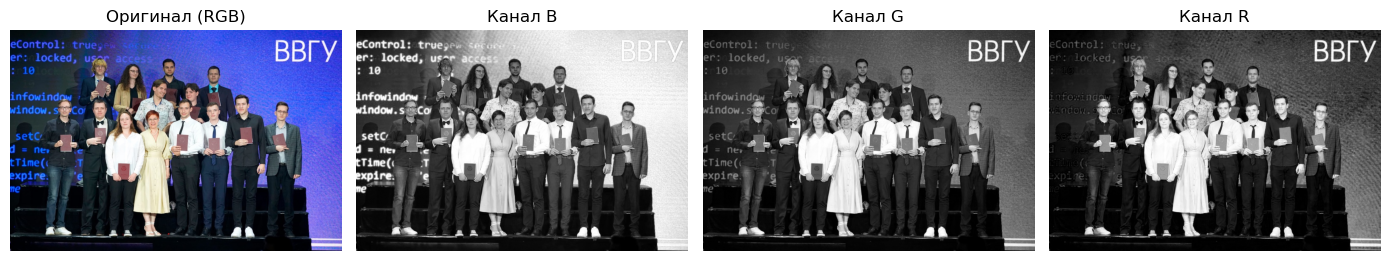

In [26]:
# Разложение на каналы (помним: порядок B, G, R в OpenCV)
b, g, r = cv2.split(img_bgr)

# Показ через Matplotlib
# Matplotlib ожидает RGB, поэтому для корректных цветов конвертируем BGR -> RGB
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img_rgb)
axs[0].set_title("Оригинал (RGB)")
axs[0].axis("off")

axs[1].imshow(b, cmap="gray")
axs[1].set_title("Канал B")
axs[1].axis("off")

axs[2].imshow(g, cmap="gray")
axs[2].set_title("Канал G")
axs[2].axis("off")

axs[3].imshow(r, cmap="gray")
axs[3].set_title("Канал R")
axs[3].axis("off")

plt.tight_layout()
plt.show()

OpenCV читает BGR, не RGB — это важно при работе с цветом.

Можно либо менять порядок каналов, либо перейти в RGB через cvtColor

## Задание 2

In [ ]:
group_img_path = "group_photo.jpeg"

img_bgr = cv2.imread(group_img_path)

# Базовые параметры изображения
h, w = img_bgr.shape[:2]
channels = img_bgr.shape[2] if img_bgr.ndim == 3 else 1
print(f"Размеры: {w} x {h} px, каналов: {channels}, dtype: {img_bgr.dtype}")


Размеры: 1086 x 724 px, каналов: 3, dtype: uint8


(np.float64(-0.5), np.float64(1085.5), np.float64(723.5), np.float64(-0.5))

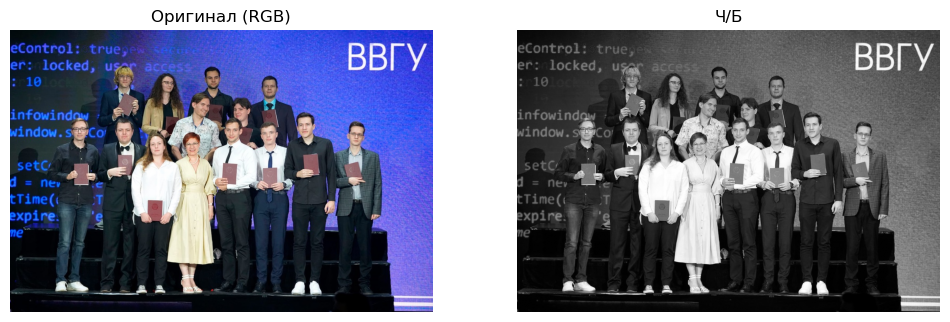

In [27]:
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
axs[0].set_title("Оригинал (RGB)")
axs[0].axis("off")

axs[1].imshow(gray, cmap="gray")
axs[1].set_title("Ч/Б")
axs[1].axis("off")

In [28]:
# Каскад лиц: ставим стандартный из поставки OpenCV
face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
face_cascade = cv2.CascadeClassifier(face_cascade_path)
assert not face_cascade.empty(), "Не найден каскад лиц. Проверь установку OpenCV."

Поиграем параметрами. Ниже - пример "рабочего" набора:

- scaleFactor: как сильно уменьшается изображение на каждом масштабе (обычно 1.05 – 1.4)
- minNeighbors: сколько "соседей" нужно для подтверждения прямоугольника (обычно 3 – 8)
- minSize: минимальный размер лица (в пикселях)

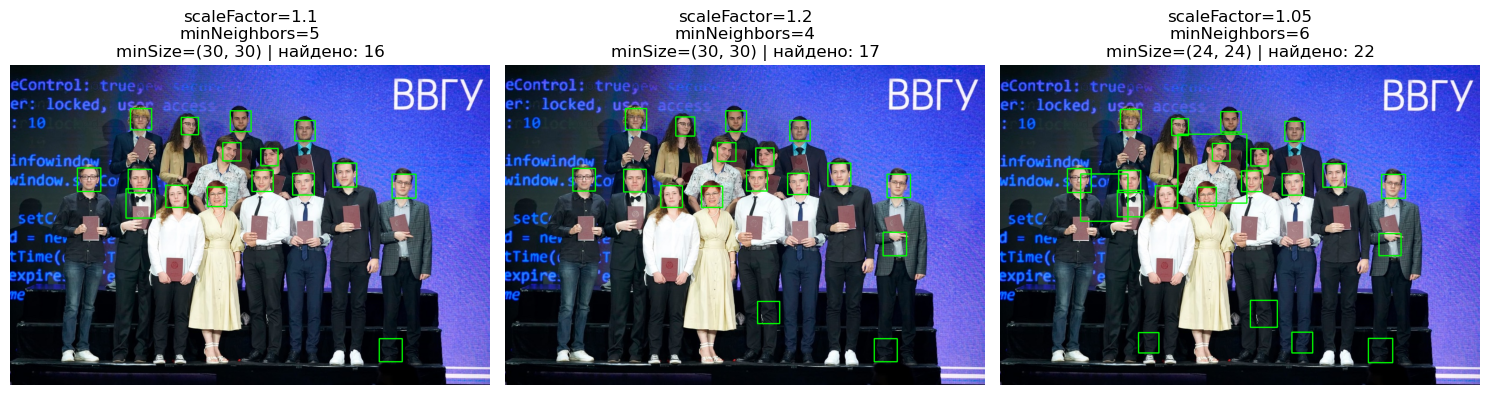

In [29]:
trial_params = [
    dict(scaleFactor=1.1, minNeighbors=5, minSize=(30, 30)),
    dict(scaleFactor=1.2, minNeighbors=4, minSize=(30, 30)),
    dict(scaleFactor=1.05, minNeighbors=6, minSize=(24, 24)),
]

# Прогоняем несколько конфигураций и показываем результаты рядом
fig, axs = plt.subplots(1, len(trial_params), figsize=(5 * len(trial_params), 5))

for ax, params in zip(np.atleast_1d(axs), trial_params):
    rects = face_cascade.detectMultiScale(gray, **params)
    vis = img_bgr.copy()
    for (x, y, w, h) in rects:
        cv2.rectangle(vis, (x, y), (x + w, y + h), (0, 255, 0), 2)

    ax.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    ax.set_title(f"scaleFactor={params['scaleFactor']}\n"
                 f"minNeighbors={params['minNeighbors']}\n"
                 f"minSize={params['minSize']} | найдено: {len(rects)}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Задание 3

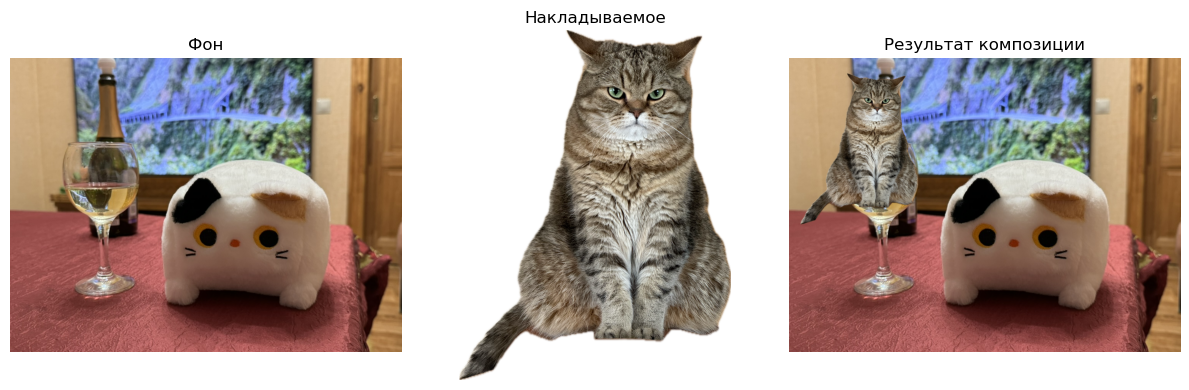

In [30]:
base_path = "base_photo.jpeg"
overlay_path = "cat_sticker.png"

base = cv2.imread(base_path, cv2.IMREAD_COLOR)
overlay = cv2.imread(overlay_path, cv2.IMREAD_UNCHANGED)

assert base is not None, "Не удалось загрузить фон"
assert overlay is not None, "Не удалось загрузить накладываемую картинку"

# Масштабирование
target_width = int(base.shape[1] * 0.3)  # 30% ширины фона
scale = target_width / overlay.shape[1]
new_size = (target_width, int(overlay.shape[0] * scale))
overlay_resized = cv2.resize(overlay, new_size, interpolation=cv2.INTER_AREA)

# Позиция размещения (верхний-левый угол)
x, y = 30, 40

# Композиция с учетом альфа-канала
result = base.copy()

h, w = overlay_resized.shape[:2]
# Ограничим область, чтобы не выйти за края
x1, y1 = max(x, 0), max(y, 0)
x2, y2 = min(x + w, base.shape[1]), min(y + h, base.shape[0])

overlay_crop = overlay_resized[(y1 - y):(y2 - y), (x1 - x):(x2 - x)]
roi = result[y1:y2, x1:x2]

overlay_rgb = overlay_crop[:, :, :3]
alpha = overlay_crop[:, :, 3:4] / 255.0  # (H,W,1) в [0..1]
# Смешиваем по альфе: out = overlay*alpha + roi*(1-alpha)
blended = (overlay_rgb * alpha + roi * (1 - alpha)).astype(np.uint8)
result[y1:y2, x1:x2] = blended

# Показ (Matplotlib, объектная нотация)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(cv2.cvtColor(base, cv2.COLOR_BGR2RGB))
ax1.set_title("Фон")
ax1.axis("off")

# overlay для показа
overlay_rgba = cv2.cvtColor(overlay, cv2.COLOR_BGRA2RGBA)
ax2.imshow(overlay_rgba)
ax2.set_title("Накладываемое")
ax2.axis("off")

ax3.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
ax3.set_title("Результат композиции")
ax3.axis("off")

plt.tight_layout()
plt.show()

# Задание 4

In [59]:
video_path = "demo_video.mp4"
background_path = "photo.jpeg"

# Открываем видео
cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), f"Не удалось открыть видео: {video_path}"

# Загружаем и подготавливаем фон
bg = cv2.imread(background_path)
assert bg is not None, f"Не удалось загрузить фон: {background_path}"

In [60]:
# Порог для зелёного цвета (в HSV)
# lower_green = (40, 40, 40)
# upper_green = (80, 255, 255)

lower_green = (45, 15, 20)
upper_green = (95, 255, 255)

# Параметры выходного видео
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS) or 25

out_path = "chroma_key_cut.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(out_path, fourcc, fps, (w, h), True)

# Основной цикл
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Фон под размер кадра
    bg_resized = cv2.resize(bg, (w, h), interpolation=cv2.INTER_AREA)

    # Переводим кадр в HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Создаём маску для зелёного фона
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Убираем шум с помощью морфологических операций
    kernel = np.ones((3, 3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel, iterations=1)

    # Инвертируем маску - оставляем человека
    mask_inv = cv2.bitwise_not(mask)

    # Вырезаем части фона и человека
    bg_part = cv2.bitwise_and(bg_resized, bg_resized, mask=mask)
    fg_part = cv2.bitwise_and(frame, frame, mask=mask_inv)

    # Комбинируем вместе
    result = cv2.add(bg_part, fg_part)

    # Сохраняем кадр
    out.write(result)

    # Для локального просмотра:
    # cv2.imshow("Chroma key", result)
    # if cv2.waitKey(1) & 0xFF == 27:
    #     break

# Освобождаем ресурсы
cap.release()
out.release()
cv2.destroyAllWindows()